In [2]:
import os
import yaml
import copy
import time
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
from xclim.indices import (
    standardized_precipitation_evapotranspiration_index,
    water_budget,
)

from xclim.indices.stats import (
    standardized_index_fit_params, 
    standardized_index
)

In [4]:
import warnings
warnings.filterwarnings("ignore", message="Converting a CFTimeIndex.*noleap.*")

In [5]:
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def detrend_linear(da, dim="time"):
    """
    Remove a best-fit linear trend along `dim` for each grid point.
    Uses an index-based time axis (0..N-1) to avoid datetime scaling issues.
    """
    t = xr.DataArray(np.arange(da.sizes[dim]), dims=dim, coords={dim: da[dim]})

    valid = np.isfinite(da)
    t_valid = t.where(valid)
    da_valid = da.where(valid)

    t_mean = t_valid.mean(dim, skipna=True)
    y_mean = da_valid.mean(dim, skipna=True)

    cov = ((t_valid - t_mean) * (da_valid - y_mean)).mean(dim, skipna=True)
    var = ((t_valid - t_mean) ** 2).mean(dim, skipna=True)

    slope = cov / var
    intercept = y_mean - slope * t_mean

    trend = slope * t + intercept
    return da - trend

In [8]:
def process_vars(data):
    """
    Preprocess data variables for SPEI calculation.
    """
    
    data["time"] = (pd.to_datetime(data["time"]).to_numpy().astype("datetime64[D]"))
    first_date = data.time.min().dt.strftime("%Y-%m-%d").values.item()
    
    if not first_date.endswith("-01-01"):
        first_year = int(first_date[:4])
        data = data.sel(time=slice(str(first_year + 1), None))

    precip = data["precip"]
    tmin = data["tmin"]
    tmax = data["tmax"]
    
    return precip, tmin, tmax
    
def calc_spei_and_params(
    precip, tmin, tmax, 
    agg_freq, start_date, end_date, 
    lat=None, dist="fisk", method="ML"):
    
    # --- Daily water budget for full period
    wb = water_budget(pr=precip, tasmin=tmin, tasmax=tmax, method="HG85", lat=lat)
    wb.attrs["units"] = "kg m-2 s-1"

    # --- Fit params on the calibration period (monthly aggregation + rolling handled inside)
    params = standardized_index_fit_params(
        wb.sel(time=slice(start_date, end_date)),
        freq="MS",           # aggregate daily WB to monthly
        window=agg_freq,     # e.g., 12 for SPEI-12
        dist=dist,           # "fisk" = 3-parameter log-logistic
        method=method,       # "PWM" (L-moments) is robust; "ML" for MLE
    )

    # --- Apply those params to the full record to get SPEI (ensures consistency)
    spei = standardized_index(
        wb,
        freq="MS",
        window=agg_freq,
        dist=dist,
        method=method,
        params=params,       # << use fixed calibration parameters
        zero_inflated=False,    # for water balance, not zero-inflated
        fitkwargs=None,         # or {}
        cal_start=None,         # not needed when params are supplied
        cal_end=None,   
    )

    # spei = standardized_precipitation_evapotranspiration_index(
    #     wb=wb, freq="MS", window=agg_freq, dist=dist, method=method, params=params
    # )
    
    if np.nanmin(spei.values) < -3:
        spei = spei.where(spei >= -3, np.nan).interpolate_na("time")

    return params, spei

def noleap_to_gregorian_add_leap(ds: xr.Dataset, time_dim: str = "time") -> xr.Dataset:
    """
    Convert cftime.DatetimeNoLeap time coord to pandas DatetimeIndex (Gregorian)
    and add Feb 29 for leap years by reindexing to a complete daily index and
    linearly filling inserted dates.
    """
    # 1) CFTimeIndex -> pandas DatetimeIndex (drops Feb 29 by definition)
    cft = ds.indexes[time_dim]                 # xarray.coding.cftimeindex.CFTimeIndex
    pd_idx = cft.to_datetimeindex()           # pandas.DatetimeIndex
    ds = ds.assign_coords({time_dim: pd_idx})

    # 2) Build full daily Gregorian index (includes Feb 29 when applicable)
    full_idx = pd.date_range(pd_idx[0], pd_idx[-1], freq="D")

    # 3) Reindex to insert missing days (Feb 29 becomes NaN rows)
    ds2 = ds.reindex({time_dim: full_idx})

    # 4) Fill inserted NaNs by linear interpolation in time
    #    (works for numeric variables; keeps non-numeric as-is)
    num_vars = [v for v in ds2.data_vars if ds2[v].dtype.kind in "fiu"]
    ds2[num_vars] = ds2[num_vars].interpolate_na(time_dim, method="linear")

    return ds2

In [9]:
def fill_nan_linear_2d(a):
    a = np.asarray(a, dtype=float)
    ny, nx = a.shape
    yy, xx = np.mgrid[0:ny, 0:nx]

    mask = np.isfinite(a)
    pts = np.column_stack((yy[mask], xx[mask]))   # (row, col) for valid points
    vals = a[mask]

    # Linear interpolation inside the convex hull of valid points
    filled = a.copy()
    filled[~mask] = griddata(pts, vals, (yy[~mask], xx[~mask]), method="linear")

    # Optional: fill any remaining NaNs (outside convex hull) with nearest
    if np.any(~np.isfinite(filled)):
        filled[~np.isfinite(filled)] = griddata(pts, vals, (yy[~np.isfinite(filled)], xx[~np.isfinite(filled)]),
                                                method="nearest")
    return filled

In [10]:
# fn_ERA5 = f'/glade/derecho/scratch/ksha/EPRI_data/ERA5_grid/ERA5_{year}.zarr'
# ds_ERA5 = xr.open_zarr(fn_ERA5)
# fn_CESM = f'/glade/derecho/scratch/ksha/EPRI_data/CESM2_SMYLE/SMYLE_{year-1}-11-01_daily_ensemble.zarr'
# ds_CESM = xr.open_zarr(fn_CESM)

### Preparing gridded yearly metrics

In [11]:
dict_loc = {
    'Pituffik': (76.4, -68.575),
    'Fairbanks': (64.75, -147.4),
    'Guam': (13.475, 144.75),
    'Yuma_PG': (33.125, -114.125),
    'Fort_Bragg': (35.05, -79.115),
}
keys = list(dict_loc.keys())

### Yuma_PG: max total precip

In [12]:
key = 'Fort_Bragg'
dir_stn = f'/glade/derecho/scratch/ksha/EPRI_data/METRICS/{key}/'
base_dir = '/glade/derecho/scratch/ksha/EPRI_data/ERA5_grid/'

In [13]:
ds_collection = []

for year in range(1958, 2026):

    # get data and variable
    fn_ERA5 = base_dir + f'/{key}/ERA5_{key}_{year}.zarr'
    ds_ERA5 = xr.open_zarr(fn_ERA5)[["total_precipitation"]]
    ds_ERA5['total_precipitation'] = ds_ERA5['total_precipitation'] * 1000
    ds_ERA5 = ds_ERA5.rename({'total_precipitation': "PRECT"})
    
    # ============ #
    # PRECT max and weekly max
    ds_TP_group = ds_ERA5[["PRECT"]].groupby("time.year")
    ds_TP_max  = ds_TP_group.max(dim="time",  skipna=True)
    ds_TP_3d = ds_TP_group.map(
        lambda x: x.rolling(time=3, min_periods=3).mean().max(dim="time", skipna=True)
    )
    ds_TP_5d = ds_TP_group.map(
        lambda x: x.rolling(time=5, min_periods=5).mean().max(dim="time", skipna=True)
    )
    
    # rename and merge ds_mean, ds_min, ds_max, ds_30d_max
    ds_TP_max = ds_TP_max.rename({v: f"{v}_max" for v in ds_TP_max.data_vars})
    ds_TP_3d = ds_TP_3d.rename({v: f"{v}_3d_max"  for v in ds_TP_3d.data_vars})
    ds_TP_5d = ds_TP_5d.rename({v: f"{v}_5d_max"  for v in ds_TP_5d.data_vars})
    # ============ #
    
    ds_merge = xr.merge([ds_TP_max, ds_TP_3d, ds_TP_5d])
    ds_collection.append(ds_merge)

ds_all = xr.concat(ds_collection, dim='year')
ds_all = ds_all.chunk({'year': 62, 'lat': 21, 'lon': 16})

In [14]:
save_name = dir_stn + 'ERA5_TP_max.zarr'
ds_all.to_zarr(save_name, mode='w')
print(save_name)

/glade/derecho/scratch/ksha/EPRI_data/METRICS/Fort_Bragg/ERA5_TP_max.zarr


### Yuma_PG: SPEI

In [15]:
ds_example = xr.open_zarr(base_dir+f'/{key}/ERA5_{key}_2019.zarr')
lat = ds_example['lat'].values
lon = ds_example['lon'].values

In [16]:
ds_collection = []

for year in range(1958, 2026):

    # get data and variable
    fn_ERA5 = base_dir + f'/{key}/ERA5_{key}_{year}.zarr'
    ds_ERA5 = xr.open_zarr(fn_ERA5)[[
        "total_precipitation", 
        "maximum_2m_temperature_since_previous_post_processing", 
        "minimum_2m_temperature_since_previous_post_processing"
    ]]
    ds_ERA5['total_precipitation'] = ds_ERA5['total_precipitation'] * 1000
    ds_ERA5 = ds_ERA5.rename(
        {
            'total_precipitation': "PRECT",
            "maximum_2m_temperature_since_previous_post_processing": 'TREFHTMX',
            "minimum_2m_temperature_since_previous_post_processing": 'TREFHTMN'
        }
    )
    ds_ERA5["TREFHTMX"] -= 273.15
    ds_ERA5["TREFHTMN"] -= 273.15
    ds_ERA5["PRECT"] = ds_ERA5["PRECT"]*1e3/86400
    
    ds_collection.append(ds_ERA5)

ds_all = xr.concat(ds_collection, dim='time')

In [17]:
Nx = len(lat)
Ny = len(lon)

SPEI_09 = np.empty((12*(2025-1958+1), Nx, Ny))
SPEI_09[...] = np.nan

SPEI_48 = np.empty((12*(2025-1958+1), Nx, Ny))
SPEI_48[...] = np.nan

In [18]:
# 62 years x 12 month

for ind_lat in range(Nx):
    for ind_lon in range(Ny):
        ds_subset = ds_all.isel(lon=ind_lon, lat=ind_lat)
        # ds_subset = ds_subset.load()
        
        lat_ref = ds_subset['lat'].values
        lat_mid = lat_ref # lat_ref[ind_lat]
        time_vals = ds_subset['time']
        
        tmin = ds_subset['TREFHTMN'].values
        tmax = ds_subset['TREFHTMX'].values
        precip = ds_subset['PRECT'].values
        
        ds = xr.Dataset(
            {
                "precip": (("time",), precip, {"units": "kg m-2 s-1"}),
                "tmin":   (("time",), tmin, {"units": "degC"}),
                "tmax":   (("time",), tmax, {"units": "degC"}),
            },
            coords={"time": time_vals, "lat": lat_mid}
        )
        
        for v in ("precip", "tmin", "tmax"):
            
            ds[v] = ds[v].assign_coords(lat=lat_mid)
            
            ds[v]["lat"].attrs = {
                "standard_name": "latitude",
                "units": "degrees_north", "axis": "Y"
            }
        
        precip, tmin, tmax = process_vars(ds)

        # ---------------------------------- #
        # 24 month lagged SPEI
        params, spei = calc_spei_and_params(
            precip, tmin, tmax, 
            agg_freq=24, 
            start_date="1958-01-01",
            end_date="2025-12-31",
            lat=precip["lat"],
            dist="fisk", method="ML"
        )
        
        SPEI_09[:, ind_lat, ind_lon] = spei.values

        # ---------------------------------- #
        # 48 month lagged SPEI
        params, spei = calc_spei_and_params(
            precip, tmin, tmax, 
            agg_freq=48, 
            start_date="1958-01-01",
            end_date="2025-12-31",
            lat=precip["lat"],
            dist="fisk", method="ML"
        )
        
        SPEI_48[:, ind_lat, ind_lon] = spei.values

In [19]:
# ======================================= #
# fill nans using linear interp
for i_time in range(12*(2025-1958+1)):
    
    spei_temp_09 = SPEI_09[i_time, :, :]
    flag_nan_09 = np.sum(np.isnan(spei_temp_09))
    
    spei_temp_48 = SPEI_48[i_time, :, :]
    flag_nan_48 = np.sum(np.isnan(spei_temp_48))

    # need to have at least 4 values in the domain
    if (flag_nan_09 < (Nx*Ny-4)) and (flag_nan_09 > 0):
        SPEI_09[i_time, :, :] = fill_nan_linear_2d(spei_temp_09)
        
    if (flag_nan_48 < (Nx*Ny-4)) and (flag_nan_48 > 0):
        SPEI_48[i_time, :, :] = fill_nan_linear_2d(spei_temp_48)

time = pd.date_range("1958-01-01", "2025-12-01", freq="MS")

ds_SPEI = xr.Dataset(
    data_vars={
        "SPEI_09": (("time", "lat", "lon"), SPEI_09),
        "SPEI_48": (("time", "lat", "lon"), SPEI_48)
    },
    coords={
        "time": time,
        "lat": lat,
        "lon": lon,
    },
)

# optional metadata
ds_SPEI["SPEI_09"].attrs["long_name"] = "SPEI with 09 month lag"
ds_SPEI["SPEI_48"].attrs["long_name"] = "SPEI with 48 month lag"

In [20]:
save_name = dir_stn + 'ERA5_SPEI.zarr'
# ds_SPEI.to_zarr(save_name)
print(save_name)

/glade/derecho/scratch/ksha/EPRI_data/METRICS/Fort_Bragg/ERA5_SPEI.zarr


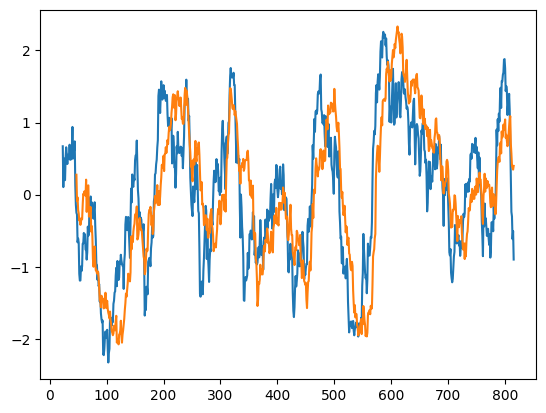

In [21]:
plt.plot(SPEI_09[:, ind_lat, ind_lon])
plt.plot(SPEI_48[:, ind_lat, ind_lon])